# Time Series Clustering Using PAA & SAX

Suppose we have data on sensor measurements for a number of difference process runs. The goal is to perform unsupervised time series clustering on these runs so as to group together runs which exhibit similar behavior. These cluster labels can then be used an an iput for modelling some other target of interest.

Data is based upon the Trace dataset found here: http://timeseriesclassification.com/description.php?Dataset=Trace

Generally, clustering based upon DTW distance offers the best performance (example shown in "Time Series Clustering Using DTW"); however, it can quickly become infeasible on large datasets given the computing resources required (it does not scale linearly). For this reason, SAX edit distance represents another viable option which drastically reduces the computing requirements while achieving simililar accuracy.

In [1]:
libname WINADO "C:\Users\winado\Desktop\Trace"; /*Define Libref*/

/*Create temporary dataset and assign run number*/
data trace;
    run+1;
    set WINADO.TRACE;
run;

/*Sort by label*/
proc sort data=trace;
	by label;
run;

/*Solution lookup*/
data solution;
	set trace;
    keep label run;
run;

title "Print first 10 records - Each row is a single run";
title2 "F[n] represents measurement taken at time n (200 runs of length 275)";
title3 "Label represents true class label for series (pretend we don't actually know this)";
title4 "Goal is to cluster the runs in such a way that we are able to assign an accurate class label to each run";
proc print data=trace(
    obs=10
    keep=f1 f2 f3 f275 label run);
run;
title;title2;title3; /*Clear titles*/

title "Frequency of true label values";
title2 "We have a total four equally distributed classes";
proc freq data=solution;
    tables label;
run;
title;

SAS Connection established. Subprocess id is 4316



Obs,run,F1,F2,F3,F275,label
1,1,0.61052,0.62126,0.69426,0.62217,1
2,2,0.62501,0.65294,0.62878,0.60855,1
3,3,0.65319,0.55613,0.67602,0.59041,1
4,4,0.59619,0.5526,0.59316,0.6173,1
5,5,0.60653,0.62571,0.63304,0.55859,1
6,6,0.57534,0.6185,0.60618,0.57317,1
7,7,0.57311,0.66785,0.62044,0.59814,1
8,8,0.58358,0.54549,0.58524,0.60546,1
9,9,0.53217,0.58283,0.63694,0.51815,1
10,10,0.62879,0.61587,0.65049,0.55126,1


run,sensor,t
1,0.61052,1
1,0.62126,2
1,0.69426,3
1,0.54682,4
1,0.57983,5

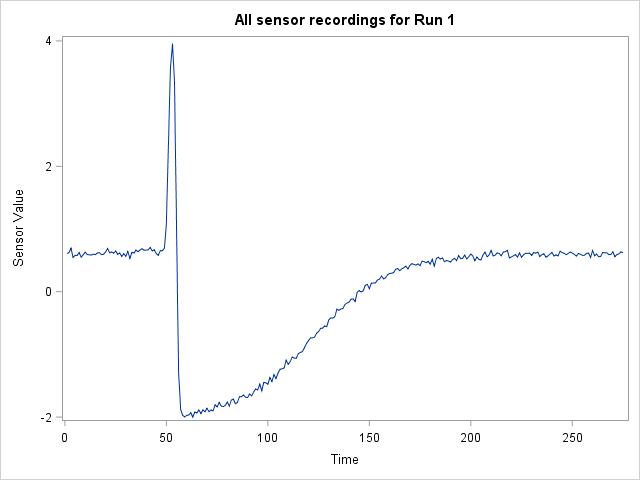
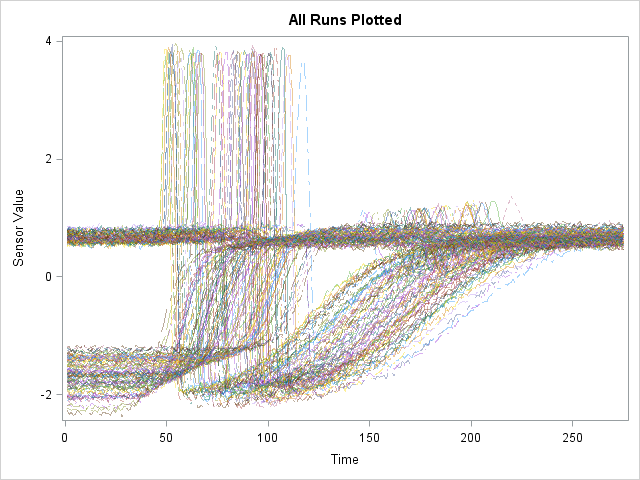

In [2]:
/*Convert to long data for graphing*/
proc transpose data=trace(drop=label) out=long(drop=_name_ rename=(COL1=sensor));
	var F: ;
	by run;
run;

/*Create time index t*/
data long;
	set long;
	by run;
	if first.run then t=0;
	t+1;
run;

title "DATA:LONG - Transposed so now each row is a second";
title2 "Sensor represents variable measure at time t";
proc print noobs data=long(obs=5);
run;
title; title2;

title "All sensor recordings for Run 1";
proc sgplot data=long (where=(run=1));
    series x=t y=sensor;
	xaxis label="Time"; yaxis label="Sensor Value";
run;
title;

title "All Runs Plotted";
proc sgplot data=long;
	series x=t y=sensor / group=run transparency=0.6;
	xaxis label="Time"; yaxis label="Sensor Value";
run;


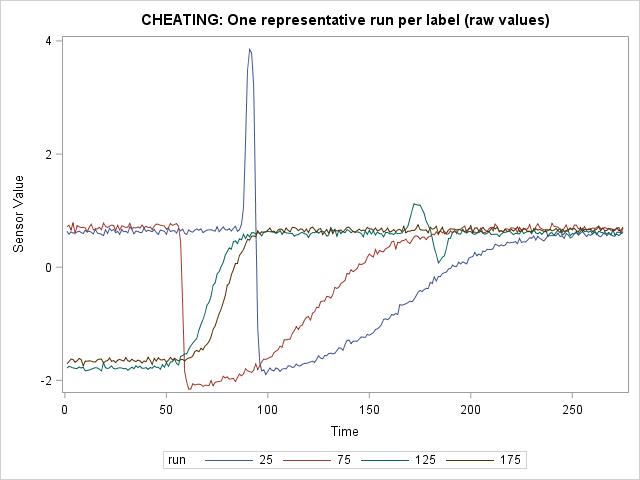

In [3]:
/*Attach true class label*/
proc sql;
	create table long as
	select *
	from long t1
	left join solution t2
	on t1.run=t2.run
	order by run, t;
quit;

title "CHEATING: One representative run per label (raw values)";
proc sgplot data=long (where=(run in (25 75 125 175)));
    series x=t y=sensor / group=run;
	xaxis label="Time"; yaxis label="Sensor Value";
run;
title;

t,run_1,run_2,run_200
1,0.43843,0.44350,0.031097
2,0.44023,0.44843,0.001562
3,0.45249,0.44417,0.018200
4,0.42774,0.43840,0.012061
5,0.43328,0.44329,0.024085
6,0.43277,0.43558,0.033313
7,0.44069,0.44353,0.018273
8,0.42826,0.43843,0.024848
9,0.43483,0.44446,0.030189
10,0.44211,0.43930,0.044175

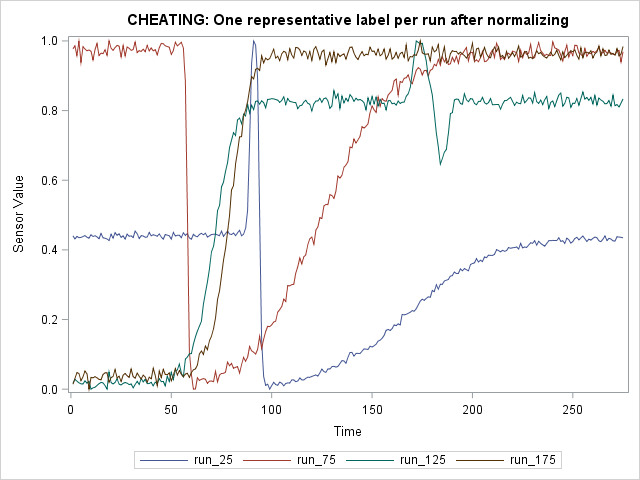

In [4]:
/*Get all runs, one column per run on common time index t*/
proc transpose data=trace out=transp(drop=_name_) prefix=run_;
	var F:;
run;

/*Create time index*/
data wide;
	length t 8.;
	set transp;
	t+1;
run;

/*Normalize all curves to between 0 and 1*/
proc stdize data=wide out=wide_std method=range;
	var run:;
run;

/*Plot normalized curves*/
title "CHEATING: One representative label per run after normalizing";
proc sgplot data=wide_std;
	series x=t y=run_25;
	series x=t y=run_75;
	series x=t y=run_125;
	series x=t y=run_175;
	xaxis label="Time"; yaxis label="Sensor Value";
run;
title;

title "DATA:WIDE_STD - Now each col is a run";
title2 "Sensor represents variable measure at time t";
proc print noobs data=wide_std(obs=10 keep=t run_1 run_2 run_200);
run;
title; title2;

In [5]:
/*Just converting wide to long for later merging with cluster membership - both for raw and std values*/

proc transpose data=wide out=long_raw;
	var run:;
	by t;
run;

proc sort data=long_raw;
	by _name_ t;
run;

data long_raw;
	set long_raw;
	rename COL1=sensor;
	run=input(substr(_name_,5),8.);
run;


proc transpose data=wide_std out=long_std;
	var run:;
	by t;
run;

proc sort data=long_std;
	by _name_ t;
run;

data long_std;
	set long_std;
	rename COL1=sensor;
	run=input(substr(_name_,5),8.);
run;

# PAA & SAX Specific Code

In [38]:
/*Converting each signal from lenth t to length &SAX_units*/
/*Converting each signal from min(sensor) to 0 and from max(sensor) to &SAX_symbols*/
%let SAX_units=11; /*Number of SAX time increments used to cover length of time t*/
%let SAX_symbols=11; /*Number of SAX symbols to use - basically the max 'height' of the SAX representation*/
/*Apply SAX - resulting in 25 discrete time units (instead of 275)*/

proc sql noprint;
	select count(t) into: t_duration from wide_std;
quit;

/*Number of time units in each SAX unit*/
%let SAX_unit_length=%sysevalf(&t_duration/&SAX_units);
%put &=SAX_unit_length;

/*Create mapping table from numeric value to SAX symbol*/
data SAX_lookup(drop=char_rank);
  input symbol $1. num 8.;
  num=0;
  output; 

  do num=1 to (&SAX_symbols-1);
  	char_rank=rank(symbol)+1;
    symbol=byte(char_rank);
    output;
  end;
  datalines;
a
run;

/*SAX format mapping for use after Piecewise Aggregate Approximation applied*/
title "SAX Numeric to Character Mapping";
proc print data=SAX_lookup;
run;

/*Create SAX format*/
data SAX_format;
	set SAX_lookup;
	retain fmtname '$SAX' type 'C';
	start=put(num,2.);
	label=symbol;
	keep fmtname start label type;
run;

/*Load SAX format for later use*/
proc format cntlin=SAX_format;
run;

/*Time index mapping - reducing from max(t)=275 to max(s)=11*/
data s_index(keep=s);
	length s i 8.;
	if _n_=1 then s=0;
	do s=1 to &SAX_units;
		do i=2 to &SAX_unit_length;
			output;
		end;
		output;
	end;
run;

data s_index;
	set s_index;
	t+1;
run;


Obs,symbol,num
1,a,0
2,b,1
3,c,2
4,d,3
5,e,4
6,f,5
7,g,6
8,h,7
9,i,8
10,j,9


In [12]:
/*Get variable names - list of runs*/
proc contents data=wide_std out=cont(keep=name);
run;

/*Load macrovariable with list of runs to loop through*/
proc sql noprint;
	select name into: run_list separated by " " from cont where name ne 't';
quit;

/*Define Piecewise Aggregate Approximation Macro*/
%macro apply_PAA;
    proc sql;
        create table PAA as
        select *
        from WINADO.WIDE_STD t1
        left join s_index t2
        on t1.t=t2.t
        order by t;
    quit;

    proc sql noprint;
        create table PAA(drop=dummy) as
        select distinct
            s,
            %do i=1 %to %sysfunc(countw(&run_list));
                %let this_run=%sysfunc(scan(&run_list,&i));
                    round(avg(&this_run),0.1)*10 as PAA_&this_run,
            %end;
            (1) as dummy
        from PAA
        group by s
        order by s;
quit;
%mend apply_PAA;
/*Simply averaging all values within each run by s*/

%apply_PAA; /*Call PAA macro*/

/*Ignore output immediately below - unable to suppress proc contents*/

s,PAA_run_1,PAA_run_2,PAA_run_3
1,4,4,4
2,4,4,4
3,2,4,4
4,1,5,4
5,2,0,3
6,3,1,0
7,4,2,1
8,4,3,3
9,4,4,4
10,4,4,4

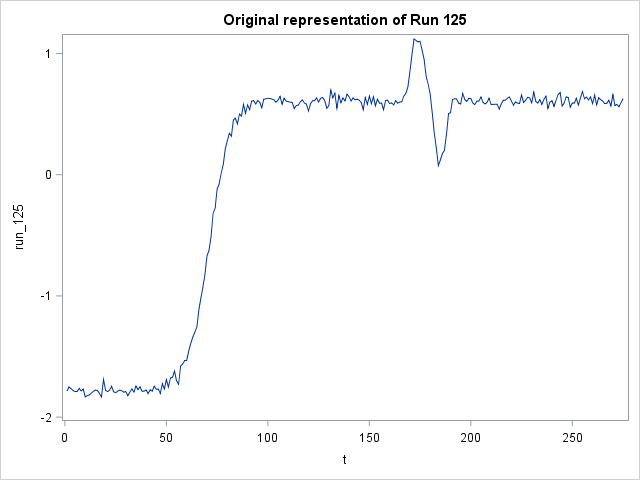
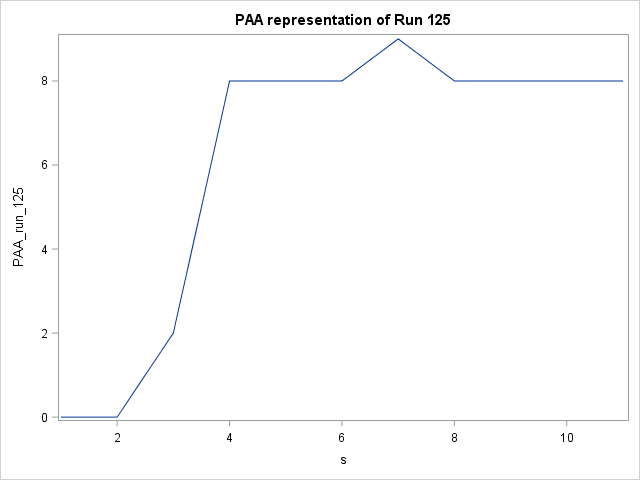
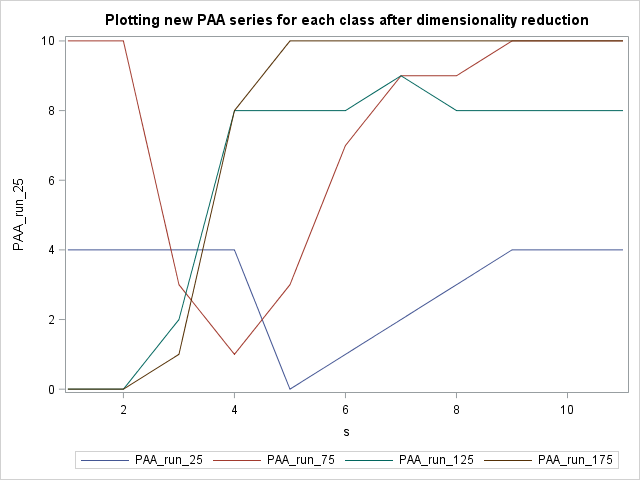

In [23]:
title "New PAA representation for first three runs";
title2 "s is SAX time index";
proc print noobs data=PAA(keep=s PAA_run_1 PAA_run_2 PAA_run_3);
run;
title; title2;

title "Original representation of Run 125";
proc sgplot data=wide;
    series x=t y=run_125;
run;

title "PAA representation of Run 125";
proc sgplot data=PAA;
    series x=s y=PAA_run_125;
run;

/* title "Plotting new PAA series for each class after dimensionality reduction";
proc sgplot data=PAA;
    series x=s y=PAA_run_25;
    series x=s y=PAA_run_75;
    series x=s y=PAA_run_125;
    series x=s y=PAA_run_175;
run;
title; */

In [24]:
/*Transpose so 1 record per run*/
proc transpose data=PAA out=PAA_transp(rename=(_name_=PAA_run)) prefix=s;
	var PAA:;
run;

title "First three runs transposed after applying PAA dimensionality reduction";
proc print data=PAA_transp(obs=3);
run;
title;

/*Apply SAX mappinng of numeric PAA to SAX character*/
%macro wrapper();
	data SAX_runs(keep=run SAX_series);
		length run 8. SAX_series $ &SAX_units;
		set PAA_transp;
		run=scan(PAA_run,3,'_');
		%do i=1 %to &SAX_units;
			s_&i=put(put(s&i,2.),$SAX.);
		%end;
		SAX_series=cats(of s_1-s_&SAX_units);
	run;
%mend;

%wrapper;

title "Frequency of SAX series representations";
proc freq data=SAX_runs order=freq;
	tables SAX_series;
	output out=SAX_freq;
run;
title;

In [25]:
/*Calculate Generalized (or Levenshtein) edit distance between all pairs of SAX series*/
proc sql;
	create table SAX_distance as
 		select 
			t1.run as run,
			t2.run as run2,
			t1.SAX_series as series1, 
			t2.SAX_series as series2,
			compged(t1.SAX_series,t2.SAX_series,999) as gedscore
/*			complev(t1.SAX_series,t2.SAX_series,&SAX_units) as levscore*/
 	from SAX_runs t1, SAX_runs t2
/* 	where t1.run < t2.run*/
	order by run, run2;
quit; 

title "Distance between runs (5 observations)";
proc print data=SAX_distance(obs=5);
run;
title;

/*Transpose to create distance matrix*/
proc transpose data=SAX_distance out=SAX_distance_matrix prefix=run_;
	var gedscore;
	by run;
	id run2;
run;

Obs,run,run2,series1,series2,gedscore
1,1,1,eecbcdeeeee,eecbcdeeeee,0
2,1,2,eecbcdeeeee,eeefabcdeee,260
3,1,3,eecbcdeeeee,eeeedabdeee,460
4,1,4,eecbcdeeeee,eeedabcdeee,260
5,1,5,eecbcdeeeee,eeefabcdeee,260


In [27]:
/*Cluster runs based on edit distance*/
proc cluster data=SAX_distance_matrix outtree=tree method=ward noprint;
   id run;
run;

/*Hierarchical clustering using 4 clusters*/
proc tree data=tree horizontal;
run;

In [34]:
%let num_clust=4; /*Split tree into this many clusters*/

proc tree data=tree ncl=&num_clust out=cluster noprint;
run;

proc sort data=cluster;
	by cluster _name_;
run;

title "Cluster Output";
proc print noobs data=cluster(obs=5 drop=clusname rename=(_name_=run));
run;

/*Merge together run values and cluster membership*/
proc sql;
	create table merge_raw as
		select *
		from long_raw t1
		left join cluster t2
		on t1._name_=t2._name_
		order by _name_, t;
quit;

proc sql;
	create table merge_std as
		select *
		from long_std t1
		left join cluster t2
		on t1._name_=t2._name_
		order by _name_, t;
quit;

run,CLUSTER
1,1
2,1
3,1
4,1
5,1


In [35]:
/*The following just formats the data to assign cluter name and label to each run*/

proc sort data=cluster;
	by cluster _name_;
run;

data cluster;
	length run 8.;
	set cluster;
	run=input(strip(_name_),8.);
run;


proc transpose data=wide_std out=transp(rename=(col1=sensor));
	var run:;
	by t;
run;

proc sort data=transp;
	by _name_ t;
run;

data transp;
	set transp;
	run=input(substr(_name_,5),8.);
run;


proc sql;
	create table clustered_runs as
	select *
	from transp t1
	left join cluster t2
	on t1.run=t2.run
	order by run, t;
quit;

title "Clustered Run Data";
proc print noobs data=clustered_runs(obs=5);
run; title;

Obs,t,_NAME_,sensor,run,CLUSTER,CLUSNAME
1,1,run_1,0.43843,1,1,CL9
2,2,run_1,0.44023,1,1,CL9
3,3,run_1,0.45249,1,1,CL9
4,4,run_1,0.42774,1,1,CL9
5,5,run_1,0.43328,1,1,CL9



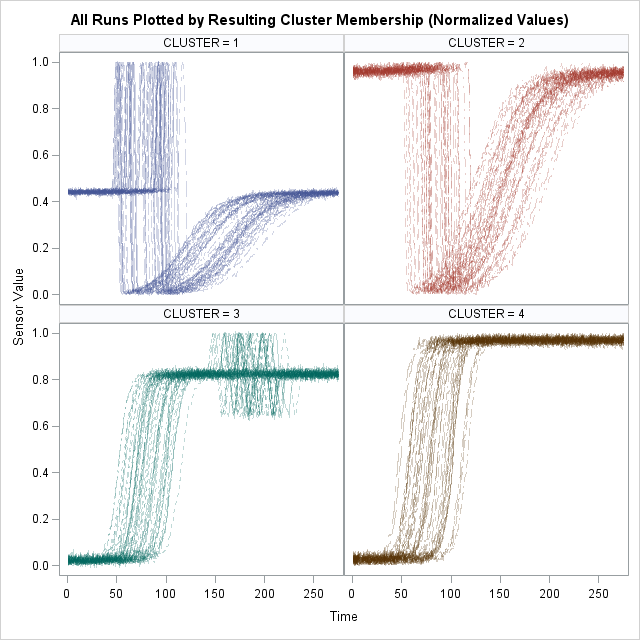

In [36]:
title "All Runs Plotted by Resulting Cluster Membership (Normalized Values)";
proc sgpanel data=clustered_runs;
	panelby cluster;
	series x=t y=sensor / group=run transparency=0.75 grouplc=cluster;
	colaxis label="Time";
	rowaxis label="Sensor Value";
run;

/*Appears that all run have been correctly clustered together*/